In [1]:
# Import necessary libraries
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import re
from typing import List, Tuple
from sklearn.metrics import f1_score

In [2]:
# Import necessary libraries
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import re
from typing import List, Tuple
from sklearn.metrics import f1_score

In [3]:
# Preprocessing class for handling text data
class TextPreprocessor:
    def __init__(self, max_len: int = 100):
        self.max_len = max_len
        self.vocab = {'<PAD>': 0, '<UNK>': 1}  # Initial vocabulary with padding and unknown tokens
        self.vocab_size = 2
    
    def tokenize(self, text: str) -> List[str]:
        """Tokenize HTML text into meaningful components."""
        # Separate HTML tags and attributes
        text = re.sub(r'([<>/="])', r' \1 ', text)
        # Remove extra whitespace
        text = ' '.join(text.split())
        return text.lower().split()
    
    def build_vocab(self, texts: List[str], min_freq: int = 2):
        """Build vocabulary with common tokens"""
        counter = Counter()
        for text in texts:
            tokens = self.tokenize(text)
            counter.update(tokens)
        
        # Add words meeting the minimum frequency threshold
        for word, freq in counter.items():
            if freq >= min_freq and word not in self.vocab:
                self.vocab[word] = self.vocab_size
                self.vocab_size += 1
    
    def encode_text(self, text: str) -> List[int]:
        """Convert text to integer sequence"""
        tokens = self.tokenize(text)
        # Truncate or pad to specified length
        if len(tokens) > self.max_len:
            tokens = tokens[:self.max_len]
        else:
            tokens.extend(['<PAD>'] * (self.max_len - len(tokens)))
        
        return [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens]


In [4]:
# Custom Dataset class for XSS data
class XSSDataset(Dataset):
    def __init__(self, texts: List[str], labels: List[int], preprocessor: TextPreprocessor):
        self.preprocessor = preprocessor
        self.encodings = [self.preprocessor.encode_text(text) for text in texts]
        self.labels = labels
        self.has_printed = False

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[torch.Tensor, torch.Tensor]:
        if idx < 3 and not self.has_printed:
            print(f"Preprocessed input {idx}: {self.encodings[idx]}")
            self.has_printed = True
        return (torch.tensor(self.encodings[idx], dtype=torch.long),
                torch.tensor(self.labels[idx], dtype=torch.float))

In [5]:
# LSTM model class for XSS detection
class XSSDetectorLSTM(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int = 50, 
                 hidden_dim: int = 64, num_layers: int = 2, dropout: float = 0.2):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        self.fc1 = nn.Linear(hidden_dim * 2, 32)
        self.fc2 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, _) = self.lstm(embedded)
        
        # Use the last time step's hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        out = self.dropout(hidden)
        out = torch.relu(self.fc1(out))
        out = torch.sigmoid(self.fc2(out))
        return out

In [6]:
# Detector class to handle training and prediction
class XSSDetector:
    def __init__(self, max_len: int = 100, device: str = None):
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = torch.device(device)
        
        self.max_len = max_len
        self.preprocessor = TextPreprocessor(max_len)
        self.model = None
        self.training_losses = []
        self.validation_losses = []
    
    def train(self, texts: List[str], labels: List[int], 
              epochs: int = 20, batch_size: int = 32, learning_rates: List[float] = [0.001, 0.002, 0.01, 0.02, 0.05],
              val_split: float = 0.1):
        
        # Build vocabulary and create dataset as before...
        self.preprocessor.build_vocab(texts)
        dataset = XSSDataset(texts, labels, self.preprocessor)
        
        # Split dataset and create loaders...
        val_size = int(len(dataset) * 0.2)
        test_size = int(len(dataset) * 0.1)
        train_size = len(dataset) - val_size - test_size

        train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
            dataset, [train_size, val_size, test_size]
        )

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)
        
        # Initialize model...
        self.model = XSSDetectorLSTM(
            vocab_size=self.preprocessor.vocab_size,
            embedding_dim=50
        ).to(self.device)
        
        for lr in learning_rates:
            print(f"Training with learning rate: {lr}")

            optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
            criterion = nn.BCELoss()
            
            # Lists to store losses
            self.training_losses = []
            self.validation_losses = []
            
            # Training loop
            for epoch in range(epochs):
                self.model.train()
                total_loss = 0
                correct = 0
                total = 0
                
                for batch_sequences, batch_labels in train_loader:
                    batch_sequences = batch_sequences.to(self.device)
                    batch_labels = batch_labels.to(self.device)
                    
                    optimizer.zero_grad()
                    outputs = self.model(batch_sequences).squeeze()
                    loss = criterion(outputs, batch_labels)
                    loss.backward()
                    optimizer.step()
                    
                    total_loss += loss.item()
                    
                    predictions = (outputs >= 0.5).float()
                    correct += (predictions == batch_labels).sum().item()
                    total += len(batch_labels)
                
                # Calculate average training loss for this epoch
                avg_train_loss = total_loss / len(train_loader)
                self.training_losses.append(avg_train_loss)
                
                # Validation
                self.model.eval()
                val_loss = 0
                val_correct = 0
                val_total = 0
                val_predictions = []
                val_true_labels = []

                with torch.no_grad():
                    for batch_sequences, batch_labels in val_loader:
                        batch_sequences = batch_sequences.to(self.device)
                        batch_labels = batch_labels.to(self.device)
                        
                        outputs = self.model(batch_sequences).squeeze()
                        val_loss += criterion(outputs, batch_labels).item()
                        
                        predictions = (outputs >= 0.5).float()
                        val_correct += (predictions == batch_labels).sum().item()
                        val_total += len(batch_labels)

                        val_predictions.extend(predictions.cpu().numpy())
                        val_true_labels.extend(batch_labels.cpu().numpy())

                # Calculate average validation loss for this epoch
                avg_val_loss = val_loss / len(val_loader)
                self.validation_losses.append(avg_val_loss)

                val_f1 = f1_score(val_true_labels, val_predictions)

                print(f'Epoch {epoch+1}/{epochs}:')
                print(f'Training Loss: {avg_train_loss:.4f}')
                print(f'Training Accuracy: {100*correct/total:.2f}%')
                print(f'Validation Loss: {avg_val_loss:.4f}')
                print(f'Validation Accuracy: {100*val_correct/val_total:.2f}%')
                print(f'Validation F1 Score: {val_f1:.4f}')

In [7]:
# Function to demonstrate the detector with example inputs
def demo_detector():
    # Load dataset
    data = pd.read_csv('dataset/XSS_dataset.csv')
    texts = data['Sentence'].tolist()
    labels = data['Label'].tolist()
    
    # Initialize detector
    detector = XSSDetector(max_len=100)
    
    # Train model
    detector.train(
        texts=texts,
        labels=labels,
        epochs=20,
        batch_size=32,
        learning_rates=[0.001, 0.002, 0.01, 0.02, 0.05]
    )

    # Plot training and validation losses
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(detector.training_losses) + 1), detector.training_losses, label='Training Loss')
    plt.plot(range(1, len(detector.validation_losses) + 1), detector.validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Test with some example cases
    test_cases = [
        "<script>alert(1)</script>",
        "<img src='x' onerror='alert(1)'>",
        "<a href='/wiki/Portal:Philosophy'>Philosophy portal</a>",
        "<span class='reference-text'>Normal text</span>"
    ]
    
    print("\nTesting some examples:")
    for test_input in test_cases:
        risk_score = detector.predict(test_input)
        print(f"Risk score for '{test_input}': {risk_score:.3f}")


Training with learning rate: 0.001


Preprocessed input 0: [2, 3, 4, 2, 5, 6, 7, 8, 9, 10, 9, 11, 8, 12, 7, 8, 13, 8, 4, 2, 14, 15, 7, 8, 16, 8, 17, 7, 8, 9, 9, 18, 9, 19, 9, 20, 9, 21, 9, 22, 9, 23, 9, 16, 9, 24, 8, 25, 7, 8, 26, 8, 27, 7, 8, 28, 8, 29, 7, 8, 30, 8, 12, 7, 8, 31, 8, 32, 7, 8, 9, 9, 18, 9, 19, 9, 20, 9, 21, 9, 22, 9, 23, 9, 16, 9, 33, 34, 9, 9, 18, 9, 19, 9, 20, 9, 21, 9, 22, 9]


Epoch 1/20:
Training Loss: 0.0976
Training Accuracy: 96.39%
Validation Loss: 0.0292
Validation Accuracy: 98.98%
Validation F1 Score: 0.9904


Epoch 2/20:
Training Loss: 0.0213
Training Accuracy: 99.28%
Validation Loss: 0.0220
Validation Accuracy: 99.20%
Validation F1 Score: 0.9925


Epoch 3/20:
Training Loss: 0.0154
Training Accuracy: 99.49%
Validation Loss: 0.0181
Validation Accuracy: 99.31%
Validation F1 Score: 0.9935


Epoch 4/20:
Training Loss: 0.0111
Training Accuracy: 99.62%
Validation Loss: 0.0149
Validation Accuracy: 99.53%
Validation F1 Score: 0.9956


Epoch 5/20:
Training Loss: 0.0072
Training Accuracy: 99.81%
Validation Loss: 0.0109
Validation Accuracy: 99.56%
Validation F1 Score: 0.9959


Epoch 6/20:
Training Loss: 0.0065
Training Accuracy: 99.77%
Validation Loss: 0.0122
Validation Accuracy: 99.63%
Validation F1 Score: 0.9966


Epoch 7/20:
Training Loss: 0.0053
Training Accuracy: 99.80%
Validation Loss: 0.0168
Validation Accuracy: 99.49%
Validation F1 Score: 0.9952


Epoch 8/20:
Training Loss: 0.0034
Training Accuracy: 99.86%
Validation Loss: 0.0151
Validation Accuracy: 99.53%
Validation F1 Score: 0.9956


Epoch 9/20:
Training Loss: 0.0015
Training Accuracy: 99.97%
Validation Loss: 0.0169
Validation Accuracy: 99.53%
Validation F1 Score: 0.9956


Epoch 10/20:
Training Loss: 0.0013
Training Accuracy: 99.93%
Validation Loss: 0.0180
Validation Accuracy: 99.56%
Validation F1 Score: 0.9959


Epoch 11/20:
Training Loss: 0.0013
Training Accuracy: 99.94%
Validation Loss: 0.0203
Validation Accuracy: 99.60%
Validation F1 Score: 0.9963


Epoch 12/20:
Training Loss: 0.0021
Training Accuracy: 99.94%
Validation Loss: 0.0305
Validation Accuracy: 99.45%
Validation F1 Score: 0.9949


Epoch 13/20:
Training Loss: 0.0032
Training Accuracy: 99.89%
Validation Loss: 0.0141
Validation Accuracy: 99.67%
Validation F1 Score: 0.9969


Epoch 14/20:
Training Loss: 0.0006
Training Accuracy: 99.98%
Validation Loss: 0.0186
Validation Accuracy: 99.63%
Validation F1 Score: 0.9966


Epoch 15/20:
Training Loss: 0.0005
Training Accuracy: 99.98%
Validation Loss: 0.0197
Validation Accuracy: 99.63%
Validation F1 Score: 0.9966


Epoch 16/20:
Training Loss: 0.0004
Training Accuracy: 99.98%
Validation Loss: 0.0230
Validation Accuracy: 99.60%
Validation F1 Score: 0.9963


Epoch 17/20:
Training Loss: 0.0002
Training Accuracy: 99.98%
Validation Loss: 0.0251
Validation Accuracy: 99.63%
Validation F1 Score: 0.9966


Epoch 18/20:
Training Loss: 0.0005
Training Accuracy: 99.98%
Validation Loss: 0.0273
Validation Accuracy: 99.60%
Validation F1 Score: 0.9963


Epoch 19/20:
Training Loss: 0.0008
Training Accuracy: 99.96%
Validation Loss: 0.0229
Validation Accuracy: 99.53%
Validation F1 Score: 0.9956


Epoch 20/20:
Training Loss: 0.0027
Training Accuracy: 99.92%
Validation Loss: 0.0200
Validation Accuracy: 99.49%
Validation F1 Score: 0.9952
Training with learning rate: 0.002


Epoch 1/20:
Training Loss: 0.0217
Training Accuracy: 99.72%
Validation Loss: 0.0197
Validation Accuracy: 99.49%
Validation F1 Score: 0.9952


Epoch 2/20:
Training Loss: 0.0018
Training Accuracy: 99.96%
Validation Loss: 0.0309
Validation Accuracy: 99.56%
Validation F1 Score: 0.9959


Epoch 3/20:
Training Loss: 0.0009
Training Accuracy: 99.98%
Validation Loss: 0.0212
Validation Accuracy: 99.53%
Validation F1 Score: 0.9956


Epoch 4/20:
Training Loss: 0.0012
Training Accuracy: 99.97%
Validation Loss: 0.0324
Validation Accuracy: 99.63%
Validation F1 Score: 0.9966


Epoch 5/20:
Training Loss: 0.0042
Training Accuracy: 99.89%
Validation Loss: 0.0206
Validation Accuracy: 99.56%
Validation F1 Score: 0.9959


Epoch 6/20:
Training Loss: 0.0025
Training Accuracy: 99.94%
Validation Loss: 0.0222
Validation Accuracy: 99.53%
Validation F1 Score: 0.9956


Epoch 7/20:
Training Loss: 0.0022
Training Accuracy: 99.95%
Validation Loss: 0.0215
Validation Accuracy: 99.60%
Validation F1 Score: 0.9963


Epoch 8/20:
Training Loss: 0.0004
Training Accuracy: 99.99%
Validation Loss: 0.0244
Validation Accuracy: 99.60%
Validation F1 Score: 0.9963


Epoch 9/20:
Training Loss: 0.0003
Training Accuracy: 99.98%
Validation Loss: 0.0253
Validation Accuracy: 99.63%
Validation F1 Score: 0.9966


Epoch 10/20:
Training Loss: 0.0003
Training Accuracy: 99.98%
Validation Loss: 0.0260
Validation Accuracy: 99.63%
Validation F1 Score: 0.9966


Epoch 11/20:
Training Loss: 0.0002
Training Accuracy: 99.99%
Validation Loss: 0.0281
Validation Accuracy: 99.60%
Validation F1 Score: 0.9963


Epoch 12/20:
Training Loss: 0.0005
Training Accuracy: 99.98%
Validation Loss: 0.0255
Validation Accuracy: 99.63%
Validation F1 Score: 0.9966


Epoch 13/20:
Training Loss: 0.0003
Training Accuracy: 99.98%
Validation Loss: 0.0257
Validation Accuracy: 99.63%
Validation F1 Score: 0.9966


Epoch 14/20:
Training Loss: 0.0002
Training Accuracy: 99.99%
Validation Loss: 0.0271
Validation Accuracy: 99.63%
Validation F1 Score: 0.9966


Epoch 15/20:
Training Loss: 0.0002
Training Accuracy: 99.98%
Validation Loss: 0.0278
Validation Accuracy: 99.63%
Validation F1 Score: 0.9966


Epoch 16/20:
Training Loss: 0.0003
Training Accuracy: 99.98%
Validation Loss: 0.0279
Validation Accuracy: 99.63%
Validation F1 Score: 0.9966


Epoch 17/20:
Training Loss: 0.0003
Training Accuracy: 99.99%
Validation Loss: 0.0284
Validation Accuracy: 99.63%
Validation F1 Score: 0.9966


Epoch 18/20:
Training Loss: 0.0002
Training Accuracy: 99.98%
Validation Loss: 0.0281
Validation Accuracy: 99.63%
Validation F1 Score: 0.9966


Epoch 19/20:
Training Loss: 0.0002
Training Accuracy: 99.99%
Validation Loss: 0.0294
Validation Accuracy: 99.56%
Validation F1 Score: 0.9959


Epoch 20/20:
Training Loss: 0.0004
Training Accuracy: 99.98%
Validation Loss: 0.0217
Validation Accuracy: 99.60%
Validation F1 Score: 0.9962
Training with learning rate: 0.01


Epoch 1/20:
Training Loss: 0.0170
Training Accuracy: 99.61%
Validation Loss: 0.0198
Validation Accuracy: 99.49%
Validation F1 Score: 0.9952


Epoch 2/20:
Training Loss: 0.0034
Training Accuracy: 99.92%
Validation Loss: 0.0251
Validation Accuracy: 99.53%
Validation F1 Score: 0.9956


Epoch 3/20:
Training Loss: 0.0016
Training Accuracy: 99.95%
Validation Loss: 0.0257
Validation Accuracy: 99.63%
Validation F1 Score: 0.9966


Epoch 4/20:
Training Loss: 0.0013
Training Accuracy: 99.95%
Validation Loss: 0.0407
Validation Accuracy: 99.53%
Validation F1 Score: 0.9956


Epoch 5/20:
Training Loss: 0.0066
Training Accuracy: 99.87%
Validation Loss: 0.0210
Validation Accuracy: 99.60%
Validation F1 Score: 0.9963


Epoch 6/20:
Training Loss: 0.0020
Training Accuracy: 99.95%
Validation Loss: 0.0224
Validation Accuracy: 99.63%
Validation F1 Score: 0.9966


Epoch 7/20:
Training Loss: 0.0005
Training Accuracy: 99.97%
Validation Loss: 0.0226
Validation Accuracy: 99.63%
Validation F1 Score: 0.9966


Epoch 8/20:
Training Loss: 0.0006
Training Accuracy: 99.98%
Validation Loss: 0.0242
Validation Accuracy: 99.71%
Validation F1 Score: 0.9973


Epoch 9/20:
Training Loss: 0.0003
Training Accuracy: 99.99%
Validation Loss: 0.0269
Validation Accuracy: 99.71%
Validation F1 Score: 0.9973


Epoch 10/20:
Training Loss: 0.0003
Training Accuracy: 99.98%
Validation Loss: 0.0274
Validation Accuracy: 99.67%
Validation F1 Score: 0.9969


Epoch 11/20:
Training Loss: 0.0002
Training Accuracy: 99.99%
Validation Loss: 0.0301
Validation Accuracy: 99.71%
Validation F1 Score: 0.9973


Epoch 12/20:
Training Loss: 0.0002
Training Accuracy: 99.99%
Validation Loss: 0.0312
Validation Accuracy: 99.71%
Validation F1 Score: 0.9973


Epoch 13/20:
Training Loss: 0.0002
Training Accuracy: 99.99%
Validation Loss: 0.0307
Validation Accuracy: 99.67%
Validation F1 Score: 0.9969


Epoch 14/20:
Training Loss: 0.0002
Training Accuracy: 99.99%
Validation Loss: 0.0317
Validation Accuracy: 99.71%
Validation F1 Score: 0.9973


Epoch 15/20:
Training Loss: 0.0002
Training Accuracy: 99.99%
Validation Loss: 0.0325
Validation Accuracy: 99.71%
Validation F1 Score: 0.9973


Epoch 16/20:
Training Loss: 0.0002
Training Accuracy: 99.99%
Validation Loss: 0.0339
Validation Accuracy: 99.71%
Validation F1 Score: 0.9973


Epoch 17/20:
Training Loss: 0.0002
Training Accuracy: 99.99%
Validation Loss: 0.0334
Validation Accuracy: 99.67%
Validation F1 Score: 0.9969


Epoch 18/20:
Training Loss: 0.0002
Training Accuracy: 99.99%
Validation Loss: 0.0345
Validation Accuracy: 99.71%
Validation F1 Score: 0.9973


Epoch 19/20:
Training Loss: 0.0002
Training Accuracy: 99.99%
Validation Loss: 0.0415
Validation Accuracy: 99.67%
Validation F1 Score: 0.9969


Epoch 20/20:
Training Loss: 0.0002
Training Accuracy: 99.98%
Validation Loss: 0.0418
Validation Accuracy: 99.67%
Validation F1 Score: 0.9969
Training with learning rate: 0.02


Epoch 1/20:
Training Loss: 0.0523
Training Accuracy: 99.52%
Validation Loss: 0.0156
Validation Accuracy: 99.49%
Validation F1 Score: 0.9952


Epoch 2/20:
Training Loss: 0.0103
Training Accuracy: 99.69%
Validation Loss: 0.0276
Validation Accuracy: 99.56%
Validation F1 Score: 0.9959


Epoch 3/20:
Training Loss: 0.0066
Training Accuracy: 99.79%
Validation Loss: 0.0420
Validation Accuracy: 99.09%
Validation F1 Score: 0.9914


Epoch 4/20:
Training Loss: 0.0170
Training Accuracy: 99.81%
Validation Loss: 0.0841
Validation Accuracy: 99.05%
Validation F1 Score: 0.9911


Epoch 5/20:
Training Loss: 0.0078
Training Accuracy: 99.81%
Validation Loss: 0.0256
Validation Accuracy: 99.38%
Validation F1 Score: 0.9942


Epoch 6/20:
Training Loss: 0.0043
Training Accuracy: 99.86%
Validation Loss: 0.0557
Validation Accuracy: 99.31%
Validation F1 Score: 0.9935


Epoch 7/20:
Training Loss: 0.0064
Training Accuracy: 99.85%
Validation Loss: 0.0810
Validation Accuracy: 99.27%
Validation F1 Score: 0.9932


Epoch 8/20:
Training Loss: 0.0052
Training Accuracy: 99.90%
Validation Loss: 0.0271
Validation Accuracy: 99.60%
Validation F1 Score: 0.9962


Epoch 9/20:
Training Loss: 0.0031
Training Accuracy: 99.92%
Validation Loss: 0.0238
Validation Accuracy: 99.53%
Validation F1 Score: 0.9956


Epoch 10/20:
Training Loss: 0.0228
Training Accuracy: 99.91%
Validation Loss: 0.0782
Validation Accuracy: 99.56%
Validation F1 Score: 0.9959


Epoch 11/20:
Training Loss: 0.0157
Training Accuracy: 99.91%
Validation Loss: 0.0346
Validation Accuracy: 99.53%
Validation F1 Score: 0.9956


Epoch 12/20:
Training Loss: 0.0074
Training Accuracy: 99.80%
Validation Loss: 0.0427
Validation Accuracy: 99.45%
Validation F1 Score: 0.9949


Epoch 13/20:
Training Loss: 0.0072
Training Accuracy: 99.82%
Validation Loss: 0.0329
Validation Accuracy: 99.53%
Validation F1 Score: 0.9956


Epoch 14/20:
Training Loss: 0.0038
Training Accuracy: 99.94%
Validation Loss: 0.0254
Validation Accuracy: 99.53%
Validation F1 Score: 0.9956


Epoch 15/20:
Training Loss: 0.0247
Training Accuracy: 99.89%
Validation Loss: 0.0237
Validation Accuracy: 99.63%
Validation F1 Score: 0.9966


Epoch 16/20:
Training Loss: 0.0273
Training Accuracy: 99.84%
Validation Loss: 0.0748
Validation Accuracy: 99.45%
Validation F1 Score: 0.9949


Epoch 17/20:
Training Loss: 0.0169
Training Accuracy: 99.74%
Validation Loss: 0.0461
Validation Accuracy: 99.31%
Validation F1 Score: 0.9935


Epoch 18/20:
Training Loss: 0.1178
Training Accuracy: 96.09%
Validation Loss: 0.1230
Validation Accuracy: 95.62%
Validation F1 Score: 0.9587


Epoch 19/20:
Training Loss: 0.1219
Training Accuracy: 95.61%
Validation Loss: 0.0761
Validation Accuracy: 98.43%
Validation F1 Score: 0.9852


Epoch 20/20:
Training Loss: 0.0697
Training Accuracy: 97.59%
Validation Loss: 0.0399
Validation Accuracy: 98.83%
Validation F1 Score: 0.9890
Training with learning rate: 0.05


Epoch 1/20:
Training Loss: 0.1404
Training Accuracy: 95.87%
Validation Loss: 0.0734
Validation Accuracy: 98.39%
Validation F1 Score: 0.9849


Epoch 2/20:
Training Loss: 0.4229
Training Accuracy: 81.68%
Validation Loss: 0.2709
Validation Accuracy: 89.66%
Validation F1 Score: 0.8980


Epoch 3/20:
Training Loss: 0.2347
Training Accuracy: 91.48%
Validation Loss: 0.0895
Validation Accuracy: 98.10%
Validation F1 Score: 0.9822


Epoch 4/20:
Training Loss: 0.1114
Training Accuracy: 96.50%
Validation Loss: 0.0905
Validation Accuracy: 97.33%
Validation F1 Score: 0.9747


Epoch 5/20:
Training Loss: 0.1024
Training Accuracy: 96.65%
Validation Loss: 0.0904
Validation Accuracy: 97.59%
Validation F1 Score: 0.9771


Epoch 6/20:
Training Loss: 0.0964
Training Accuracy: 96.97%
Validation Loss: 0.0597
Validation Accuracy: 97.70%
Validation F1 Score: 0.9783


Epoch 7/20:
Training Loss: 0.0649
Training Accuracy: 97.96%
Validation Loss: 0.0634
Validation Accuracy: 98.28%
Validation F1 Score: 0.9839


Epoch 8/20:
Training Loss: 0.0561
Training Accuracy: 98.39%
Validation Loss: 0.0610
Validation Accuracy: 98.10%
Validation F1 Score: 0.9821


Epoch 9/20:
Training Loss: 0.0713
Training Accuracy: 97.93%
Validation Loss: 0.0498
Validation Accuracy: 98.50%
Validation F1 Score: 0.9859


Epoch 10/20:
Training Loss: 0.0703
Training Accuracy: 97.84%
Validation Loss: 0.0546
Validation Accuracy: 98.32%
Validation F1 Score: 0.9842


Epoch 11/20:
Training Loss: 0.0612
Training Accuracy: 98.12%
Validation Loss: 0.0440
Validation Accuracy: 98.68%
Validation F1 Score: 0.9876


Epoch 12/20:
Training Loss: 0.0521
Training Accuracy: 98.64%
Validation Loss: 0.0696
Validation Accuracy: 98.47%
Validation F1 Score: 0.9856


Epoch 13/20:
Training Loss: 0.0457
Training Accuracy: 98.77%
Validation Loss: 0.0442
Validation Accuracy: 98.98%
Validation F1 Score: 0.9904


Epoch 14/20:
Training Loss: 0.2948
Training Accuracy: 83.71%
Validation Loss: 0.6901
Validation Accuracy: 53.78%
Validation F1 Score: 0.6989


Epoch 15/20:
Training Loss: 0.7096
Training Accuracy: 55.87%
Validation Loss: 0.6694
Validation Accuracy: 57.87%
Validation F1 Score: 0.7161


Epoch 16/20:
Training Loss: 0.6294
Training Accuracy: 65.12%
Validation Loss: 0.5588
Validation Accuracy: 76.14%
Validation F1 Score: 0.8035


Epoch 17/20:
Training Loss: 0.6084
Training Accuracy: 67.87%
Validation Loss: 0.4800
Validation Accuracy: 77.60%
Validation F1 Score: 0.8057


Epoch 18/20:
Training Loss: 0.6135
Training Accuracy: 68.04%
Validation Loss: 0.6132
Validation Accuracy: 64.38%
Validation F1 Score: 0.7471


Epoch 19/20:
Training Loss: 0.5687
Training Accuracy: 71.88%
Validation Loss: 0.4617
Validation Accuracy: 80.82%
Validation F1 Score: 0.8329


Epoch 20/20:
Training Loss: 0.5304
Training Accuracy: 74.30%
Validation Loss: 0.4924
Validation Accuracy: 75.08%
Validation F1 Score: 0.7936


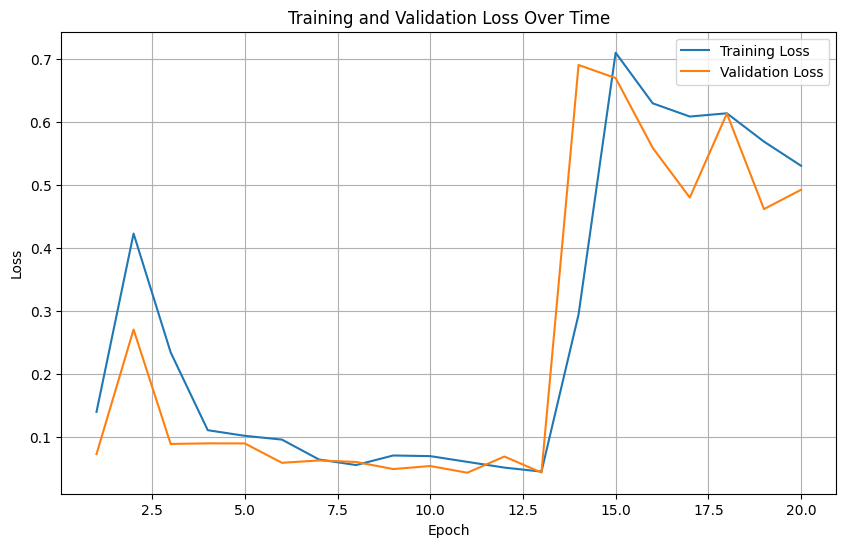


Testing some examples:


AttributeError: 'XSSDetector' object has no attribute 'predict'

In [8]:
# Run demonstration
if __name__ == "__main__":
    demo_detector()